# 2020-08-27

## Analyzing Rpb1-MS2 movies, continued

This is a continuation of notebook 10, with improved spot detection as inputs



In [134]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
%matplotlib inline

# Import my packages.
import sys
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

In [2]:
from random import random
def random_spot_data(spot_data, mask, n):
    """Produce spot_data for spots in random positions within nuclei, constrained by HLB mask"""
    rand_spot_data = {}
    for spot in spot_data:
        rand_spot_data[spot] = np.ndarray((spot_data[spot].shape[0] * n, spot_data[spot].shape[1]))
        rownum=0
        arr = spot_data[spot]
        for row in arr:
            t, nuc, z = [int(x) for x in row[0:3]]
            x,y = np.where(mask[t,z] == nuc)
            numpix = len(x)
            for i in range(0, n):
                rand = int(numpix * random())
                randx, randy = x[rand], y[rand]
                newrow = row.copy()
                newrow[3:5] = [randx, randy]
                rand_spot_data[spot][rownum] = newrow
                rownum = rownum + 1
    return rand_spot_data
#e=random_spot_data(mv.spot_data, np.where(a, 0, mv.nucmask),2)

In [135]:
#sna1 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20200825-rpb1Snams2-em1-zsmv-03-05.pkl')
#sna2 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20200825-rpb1Snams2-em1-zsmv-07-09.pkl')
eve1 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180811-rpb1-eve-em1-zsmv-06.pkl')

In [202]:
eve2 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180811-rpb1-eve-em1-zsmv-03.pkl')
eve3 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180811-rpb1-eve-em2-zsmv-04-05.pkl')

In [3]:
def plot_traces2(table1, table2, windowsize=1):
    """Compare two integrations using grand min and max to normalize"""
    num_to_plot= table1.shape[1]
    
    def norm(data, x):
        # Double min and max takes grand mean of the array
        data_norm = (data[x] - data.min().min()) / (data.max().max() - data.min().min())
        return(data_norm)
    
    def test(x):
        data = norm(table1, x).rolling(windowsize, center=True).mean()
        plt.plot(data.index, data.values, marker="o", color="blue", markersize=4)
        data2 = norm(table2, x).rolling(windowsize, center=True).mean()
        plt.plot(data2.index, data2.values, marker="o", color="orange", markersize=4)
        plt.title(x)
        
    imp.plot_ps(test, range(1,num_to_plot+1))

In [4]:
def plot_traces_base(table1, table2, windowsize=1):
    """Compare two integrations, normalize each trace 0 to 1"""
    num_to_plot= table1.shape[1]
    
    def norm(data, x):
        data_norm = (data[x] - data[x].min()) / (data[x].max() - data[x].min())
        return(data_norm)
    
    def test(x):
        data = norm(table1, x).rolling(windowsize, center=True).mean()
        data.plot(marker="o", color="blue") 
        #data2 = norm(table2, x)
        data2 = norm(table2, x).rolling(windowsize, center=True).mean()
        data2.plot(marker="p", color="orange")
        plt.title(x)
        
    imp.plot_ps(test, range(1,num_to_plot+1))



In [5]:
def plot_vs(data1, data2, maxval=np.inf):
    data1 = data1.copy()
    data2 = data2.copy()
    data1 = data1.to_numpy().flatten()
    data2 = data2.to_numpy().flatten()
    data1 = data1[~np.isnan(data1)]
    data2 = data2[~np.isnan(data2)]
    data1 = data1[data2 <= maxval]
    data2 = data2[data2 <= maxval]
    m, b = np.polyfit(data1, data2, 1)
    x = np.arange(0, data1.max())
    plt.scatter(data1, data2, alpha=1)
    plt.plot(x, m*x + b, color="black")
    print(spearmanr(data1, data2))
    print(pearsonr(data1, data2))

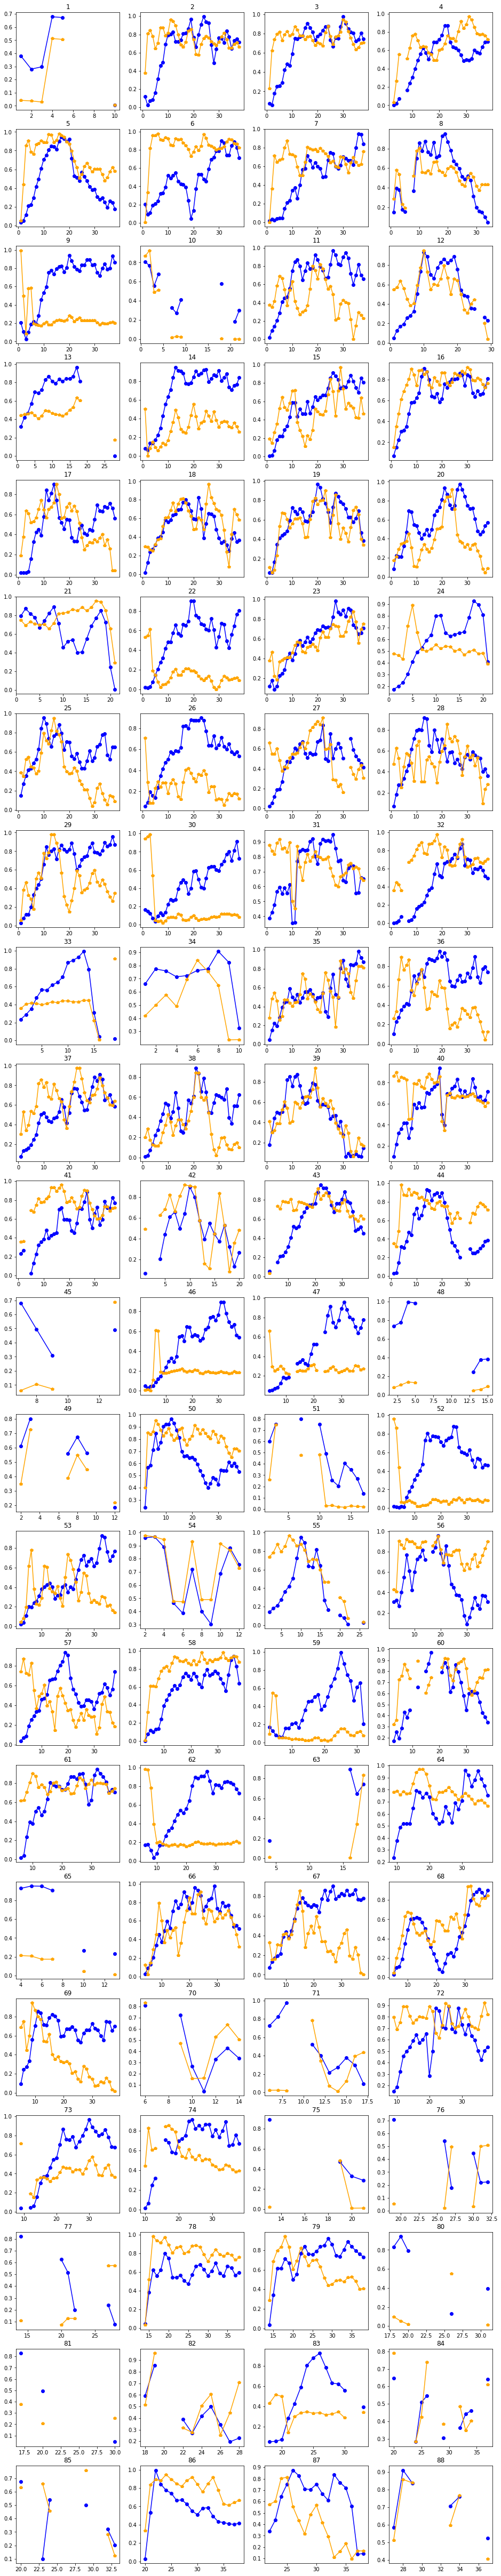

In [8]:
plot_traces_base(sna1.intvol, sna1.prot, 2)

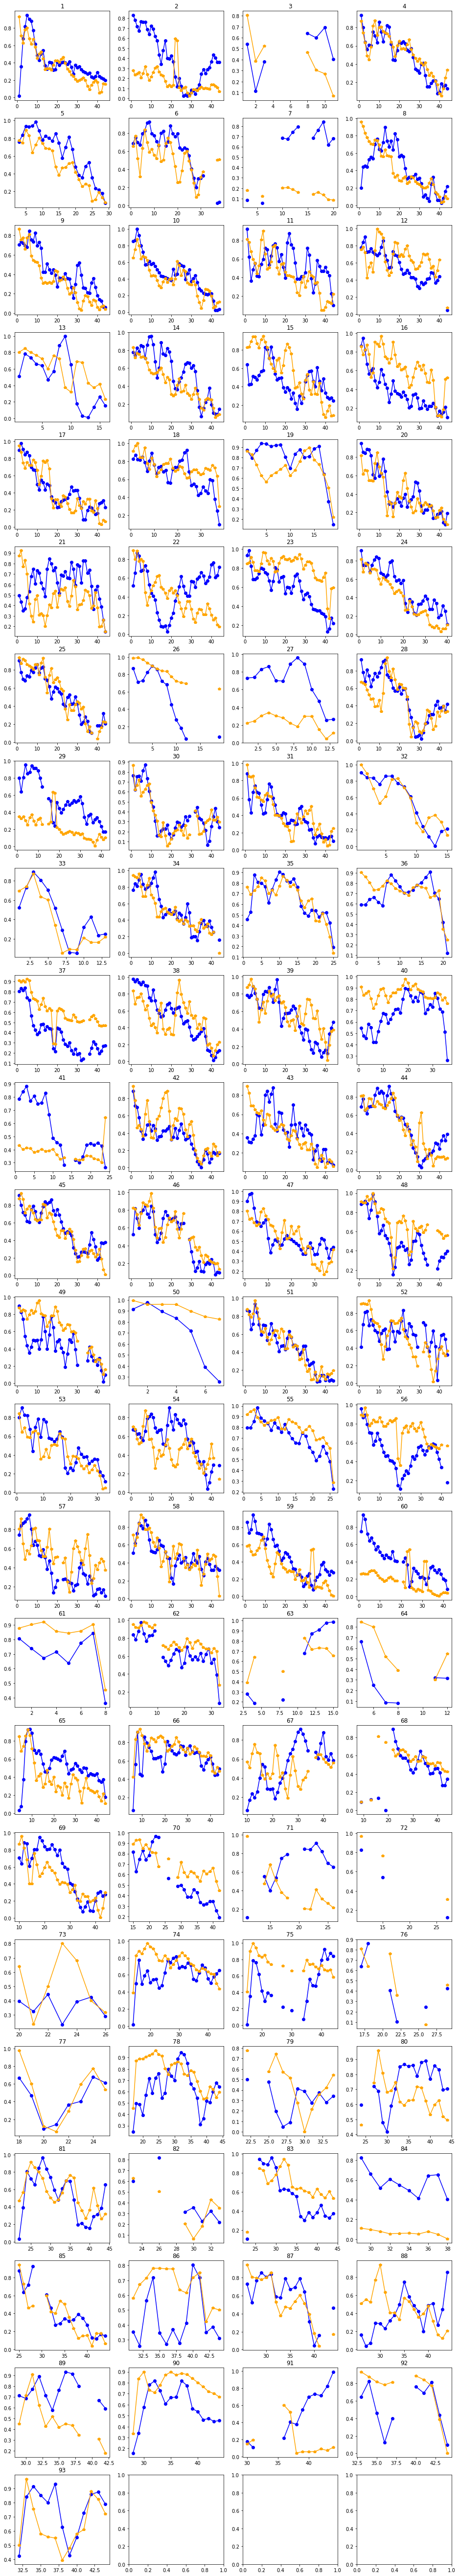

In [9]:
plot_traces_base(sna2.intvol, sna2.prot, 2)

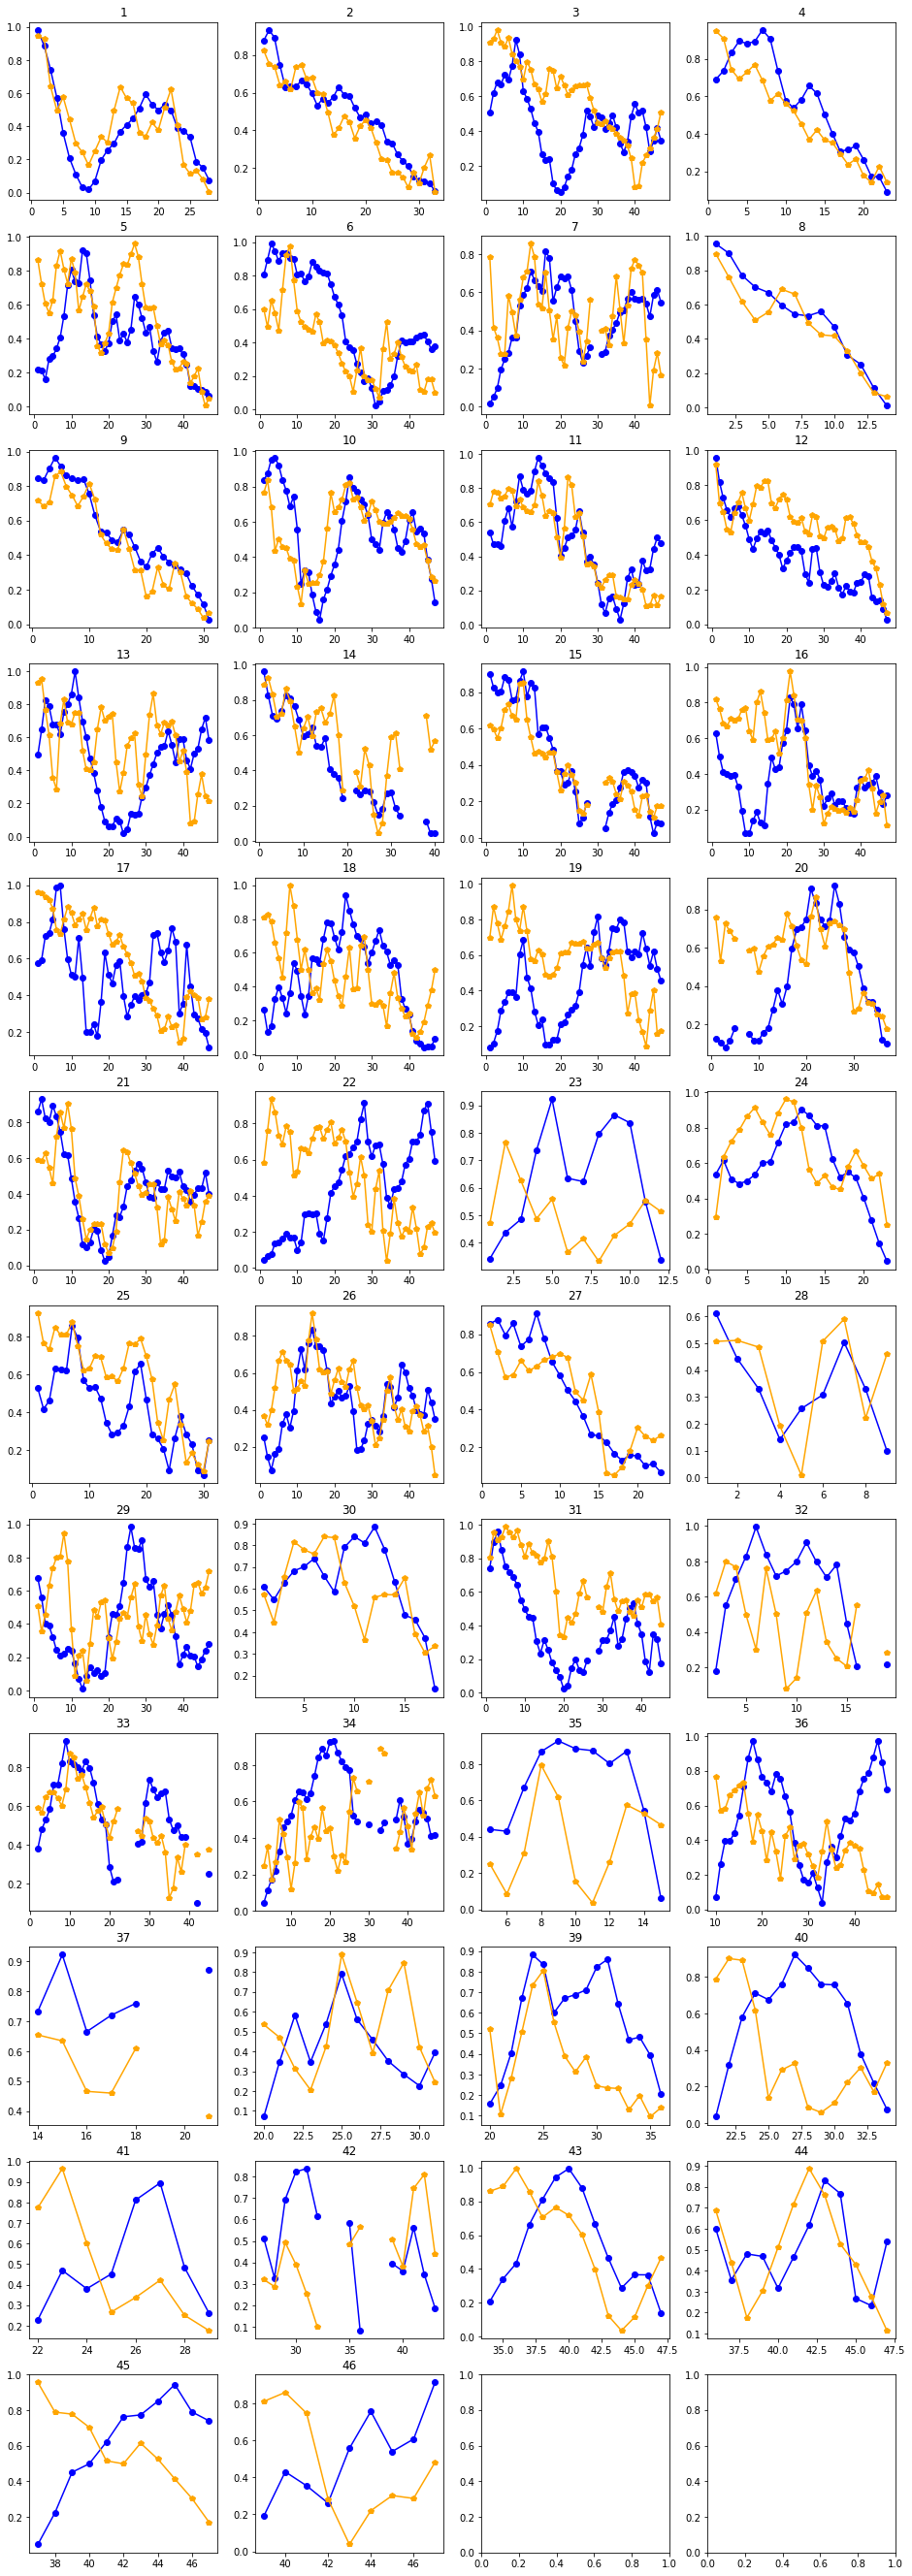

In [10]:
plot_traces_base(eve1.intvol, eve1.prot, 2)

In [21]:
sm = imp.spot_movies(mv1.stack, mv1.spot_data, 1,37, fill=0, view=False)

In [22]:
viewer(sm)

interactive(children=(Dropdown(description='Color', index=3, options=('plasma', 'viridis', 'cividis', 'Greens'…

### Bleaching correction

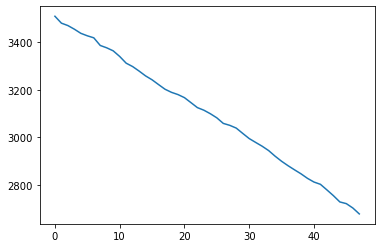

In [21]:
stack = eve1.stack[0]
means = []
for t in range(0, len(stack)):
    means.append(stack[t].mean())
    
plt.plot(means);

In [22]:
# simple linear bleaching correction
v=[]
channel=0
mv = eve1

prot = mv.prot.copy()
intvol = mv.intvol.copy()
stack = mv.stack[channel].copy()
for t in range(0, stack.shape[0]):
    v.append(np.mean(stack[t]))

#stack_corr = stack.copy()
for i in range(0, len(v)):
    corr = max(v) - v[i]
    prot.iloc[i] = prot.iloc[i] + corr
    intvol.iloc[i] = intvol.iloc[i] + corr

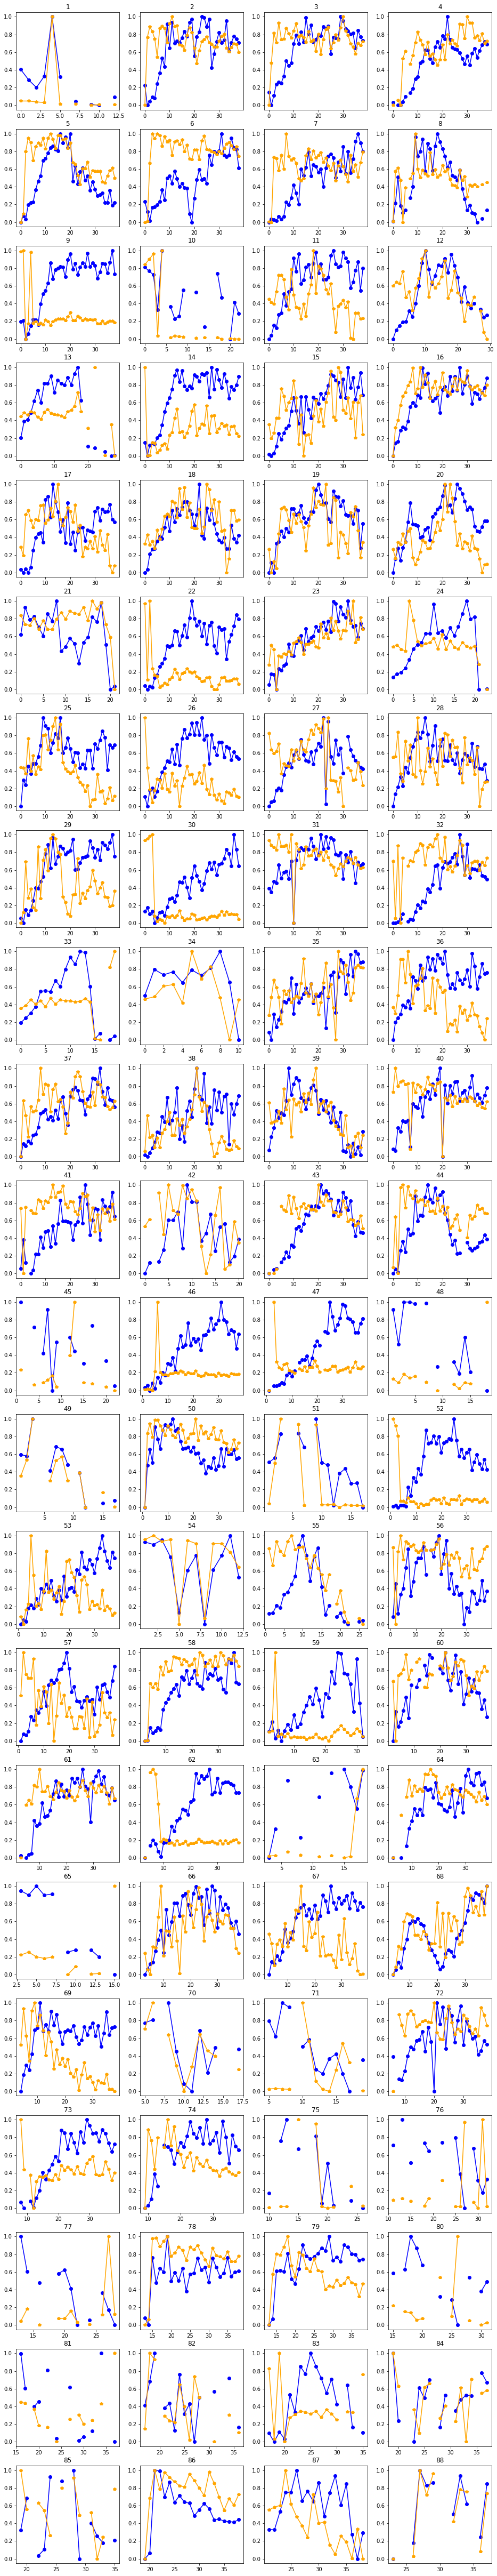

In [196]:
plot_traces_base(sna1_intvol_bc, sna1_prot_bc, 1)

In [29]:
sm0 = imp.spot_movies(eve1.stack, eve1.spot_data, 0,27, fill=0, view=False)
sm1 = imp.spot_movies(eve1.stack, eve1.spot_data, 1,27, fill=0, view=False)

In [31]:
viewer([sm0,sm1], 6)

interactive(children=(Dropdown(description='Color', index=8, options=('Reds', 'inferno', 'cividis', 'gray_r', …

In [207]:
eve1.intvol_bc, eve1.prot_bc = bleach_corr(eve1)
eve2.intvol_bc, eve2.prot_bc = bleach_corr(eve2)
eve3.intvol_bc, eve3.prot_bc = bleach_corr(eve3)
sna1.intvol_bc, sna1.prot_bc = bleach_corr(sna1)
sna2.intvol_bc, sna2.prot_bc = bleach_corr(sna2)

173


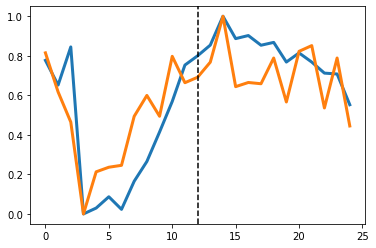

In [390]:
mvs = [eve1, eve2, eve3]
min_ = 20
win = 5
lag = 7
thresh = 0.02

plot_triggered(mvs, min_, win, lag, thresh, rise=True)


207


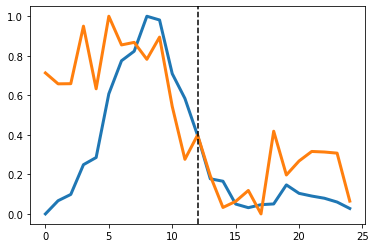

In [384]:
mvs = [eve1, eve2, eve3]
min_ = 20
win = 4
lag = 5
thresh = 0.02

plot_triggered(mvs, min_, win, lag, thresh, rise=False)

254


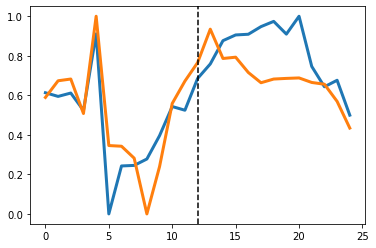

In [385]:
mvs = [eve1, eve2, eve3]
min_ = 20
win = 4
lag = 5
thresh = 0.025

plot_triggered(mvs, min_, win, lag, thresh, rise=True, trig_from_prot=True)

266


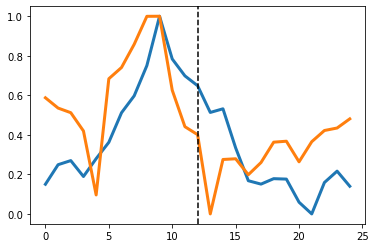

In [386]:
mvs = [eve1, eve2, eve3]
min_ = 20
win = 4
lag = 5
thresh = 0.025

plot_triggered(mvs, min_, win, lag, thresh, rise=False, trig_from_prot=True)

178


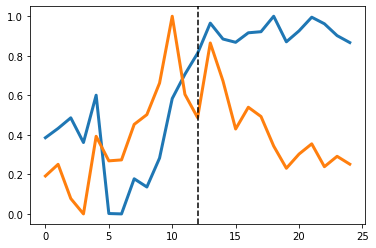

In [387]:
mvs = [sna1, sna2]
min_ = 20
win = 4
lag = 5
thresh = 0.1

plot_triggered(mvs, min_, win, lag, thresh, rise=True)

## Calling burst rises and falls

Need to collapse consecutive positions. coded up a graphical readout of burst calls.

In [6]:
def findrises(df, windowsize, lag, threshold, rise=True, norm=True, display=False):
    events = []
    for spot in df:
        data = df[spot].copy()
        if (norm):
            data_norm = (data - data.min()) / (data.max() - data.min())
        else:
            data_norm = data
        rolling_avg = data_norm.rolling(windowsize, center=True).mean()
        diff = rolling_avg.diff(lag)
        if rise:
            indices = np.where(diff > threshold)
        else:
            indices = np.where(diff < (-1 * threshold))
        
        last_index = [0,0]
        for i in indices[0]:
            # In a run of consecutive indexes.
            if (last_index == [spot, i-1]):
                last_index = [spot, i]
            else:
                events.append([spot, i])
                last_index = [spot, i]
            
    if display:
        nframes = len(df)
        ax = imp.qax(nframes+1)

        for n in range(1, nframes-1):
            ax[n].plot(df[n])
            for event in events:
                if (event[0] == n):
                    pass
                    ax[n].axvline([event[1]], color="black", linestyle="--")
    return events


In [7]:
def plot_triggered(mvs, min_, win, lag, thresh, rise=True, norm=True, trig_from_prot=False):
    
    def norm_trace(x):
        return (x - x.min()) / (x.max() - x.min())
    
    intvol = df_filter_len(mvs[0].intvol_bc, min_)
    prot = df_filter_len(mvs[0].prot_bc, min_)
    for i in range(1, len(mvs)):
        intvol = pd.concat([intvol, df_filter_len(mvs[i].intvol_bc, min_)])
        prot = pd.concat([prot, df_filter_len(mvs[i].prot_bc, min_)])
    
    if trig_from_prot:
        frames = findrises(prot, win, lag, thresh, rise=rise)
    else:
        frames = findrises(intvol, win, lag, thresh, rise=rise)
    print(len(frames))
    
    intvol_means = imp.align_traces(norm01(intvol), frames, 25).mean();
    prot_means = imp.align_traces(norm01(prot), frames, 25).mean();
    if (norm):
        norm_trace(intvol_means).plot(linewidth=3)
        norm_trace(prot_means).plot(linewidth=3)
    else:
        intvol_means.plot()
        prot_means.plot()
    plt.axvline([12], color="black", linestyle="--");

In [8]:
def df_filter_len(df, n):
    return df.iloc[:,np.count_nonzero(~np.isnan(df), axis=0) > n]

In [9]:
def norm01(df):
    df = df.copy()
    for i in df:
        df[i] = (df[i] - df[i].min()) / (df[i].max() - df[i].min())
    return df

In [10]:
# simple linear bleaching correction

def bleach_corr(mv):
    prot = mv.prot.copy()
    intvol = mv.intvol.copy()
    p = []
    m = []
    for t in range(0, mv.stack[0].shape[0]):
        m.append(np.mean(mv.stack[1, t]))
        p.append(np.mean(mv.stack[0, t]))

    protcorr = prot.copy()
    intvolcorr = intvol.copy()
    for i in range(0, len(m)):
        mcorr = max(m) - m[i]
        intvolcorr.iloc[i] = intvolcorr.iloc[i] + mcorr
       
        pcorr = max(p) - p[i]
        protcorr.iloc[i] = protcorr.iloc[i] + pcorr
    
    return intvolcorr, protcorr

eve1_intvol_bc, eve1_prot_bc = bleach_corr(eve1)
eve1.prot.mean(axis=1).plot();
eve1_prot_bc.mean(axis=1).plot();

NameError: name 'eve1' is not defined

In [11]:
def findrises(df, windowsize, lag, threshold, rise=True, norm=True, display=False):
    events = []
    for spot in df:
        data = df[spot].copy()
        if (norm):
            data_norm = (data - data.min()) / (data.max() - data.min())
        else:
            data_norm = data
        rolling_avg = data_norm.rolling(windowsize, center=True).mean()
        diff = rolling_avg.diff(lag)
        if rise:
            indices = np.where(diff > threshold)
        else:
            indices = np.where(diff < (-1 * threshold))
        
        last_index = [0,0]
        for i in indices[0]:
            # In a run of consecutive indexes.
            if (last_index == [spot, i-1]):
                last_index = [spot, i]
            else:
                events.append([spot, i])
                last_index = [spot, i]
            
    if display:
        nframes = len(df)
        ax = imp.qax(nframes+1)

        for n in range(1, nframes-1):
            ax[n].plot(df[n])
            for event in events:
                if (event[0] == n):
                    pass
                    ax[n].axvline([event[1]], color="black", linestyle="--")
    return events

# 2020-09-09: Developing ways to call bursts

I want to at least try my hand at making a simple HMM to fit the traces. Unclear how useful it would be but it's at least something to learn. Going to try to work through hmmlearn to start.

In [122]:
>>> from hmmlearn import hmm
>>>
>>> model = hmm.GaussianHMM(n_components=2, covariance_type="full")
>>> model.startprob_ = np.array([0.6, 0.4])
>>> model.transmat_ = np.array([[0.9, 0.1],
...                             [0.1, 0.9]])
model.means_ = np.array([[0.2], [0.8]])
model.covars_ = np.tile([0.05], (2, 1, 1))
#model.covars_ = [[0.5], [0.5]]
X, Z = model.sample(100)

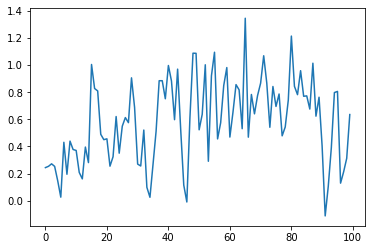

In [123]:
plt.plot(X)

In [130]:
>>> remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)


In [131]:
remodel.covars_

AttributeError: 'GaussianHMM' object has no attribute '_covars_'

In [132]:
>>> remodel.fit(X)

GaussianHMM(covariance_type='full', n_components=2, n_iter=100)

In [133]:
remodel.covars_

array([[[0.02784732]],

       [[0.0444356 ]]])

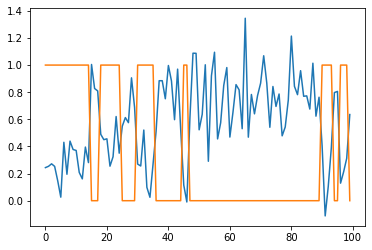

In [129]:
plt.plot(X)
plt.plot(Z2)

In [136]:
eve1.intvol

1            2            3            4            5   \
0   4990.090323  3715.206452  2522.458065  3499.264516  2043.006452   
1   4844.148387  4657.709677  2211.225806  3618.780645  2727.877419   
2   4238.664516  4142.083871  3065.412903  3840.161290  2022.322581   
3   3730.425806  4336.477419  2516.632258  4343.432258  2403.819355   
4   2915.277419  3023.432258  2996.516129  4296.129032  2750.019355   
5   2063.954839  3444.941935  2789.322581  4253.070968  2499.264516   
6   1739.393548  3036.206452  2848.883871  4369.174194  3030.509677   
7   1303.219355  3458.077419  3188.877419  4717.567742  2899.445161   
8   1141.787097  3253.200000  3570.748387  4011.367742  3805.283871   
9   1191.406452  3325.303226  2789.993548  3432.361290  4000.677419   
10  1550.122581  2875.883871  2535.929032  2847.329032  4343.832258   
11  2183.741935  2828.470968  2582.154839  3128.341935  3600.587097   
12  2009.238710  3162.438710  2243.451613  3190.658065  4277.432258   
13  2482.961290  2659.658065  2186.161290  3671.941935  4765.993548   
14  2582.129032  3398.651613  2009.890323  2888.838710  4183.690323   
15  2795.083871  3067.509677  1545.748387  2827.341935  3807.135484   
16  2875.251613  3077.490323  1853.277419  2130.890323  2926.748387   
17  3284.600000  3007.696774  1575.374194  2122.638710  3027.903226   
18  3534.870968  2602.303226  1162.012903  2206.006452  2661.251613   
19  2806.322581  2613.903226  1379.638710  2265.245161  2795.696774   
20  3260.619355  2730.870968  1121.148387  1662.367742  2929.535484   
21  3065.600000  2242.283871  1509.303226  1589.167742  3575.554839   
22  2992.116129  2811.232258  1430.703226  1652.896774  3170.845161   
23  2251.141935  2100.877419  1697.903226   986.006452  2659.438710   
24  2843.767742  2135.070968  1867.567742          NaN  3397.812903   
25  1958.064516  2029.851613  1864.806452          NaN  2369.174194   
26  1688.154839  1668.038710  2233.335484          NaN  3849.109677   
27  1685.374194  1760.077419  2535.522581          NaN  3535.354839   
28  1097.522581  1476.729032  2075.464516          NaN  3569.367742   
29          NaN  1313.935484  2230.954839          NaN  3049.529032   
30          NaN  1318.961290  2423.638710          NaN  3065.006452   
31          NaN  1291.761290  2163.341935          NaN  3257.858065   
32          NaN  1225.612903  2100.948387          NaN  2187.845161   
33          NaN   970.025806  2338.012903          NaN  2872.580645   
34          NaN          NaN  2314.335484          NaN  2907.961290   
35          NaN          NaN  1995.645161          NaN  3206.212903   
36          NaN   882.348387  1855.335484          NaN  2957.251613   
37          NaN          NaN  1767.361290          NaN  2595.206452   
38          NaN   805.200000  2138.064516          NaN  2923.922581   
39          NaN          NaN  2485.703226          NaN  2605.677419   
40          NaN          NaN  2481.987097          NaN  2717.748387   
41          NaN          NaN  2232.896774          NaN  2249.270968   
42          NaN          NaN  2539.458065          NaN  1931.238710   
43          NaN          NaN  1770.122581          NaN  2268.619355   
44          NaN          NaN  1860.470968          NaN  1823.735484   
45          NaN          NaN  2070.303226          NaN  2233.877419   
46          NaN          NaN  2210.335484          NaN  1731.400000   
47          NaN          NaN  1738.470968          NaN  2127.258065   

             6            7            8            9            10  ...  \
0   4206.096774  1451.864516  3400.090323  3896.864516  2929.135484  ...   
1   4184.167742  1357.167742  3659.322581  3566.451613  2674.348387  ...   
2   4932.296774  1638.806452  3085.348387  3818.548387  3053.354839  ...   
3   4935.354839  1610.748387  2928.890323  4002.922581  2960.051613  ...   
4   4589.341935  2185.167742  2693.270968  4230.877419  3086.645161  ...   
5   4448.541935  1908.825806  2754.135484  3687.161290  2807.664516  ...   
6